In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from scipy.stats import zscore

# Sklearn imports for scaling, splitting, modeling, evaluation, and hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Additional libraries for boosting models
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier

In [3]:
# Example: Download data using yfinance library (install it if needed: pip install yfinance)
import yfinance as yf

# Define the ticker symbol (e.g., "AAPL" for Apple Inc.)
ticker = "AAPL"

# Download historical data (last 5 years)
data = yf.download(ticker, period="5y", interval="1d")

# Save the data to a CSV file for later use
data.to_csv("data/stock_data.csv")

# Display the first few rows
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800
2020-03-06,70.141525,70.575923,68.248632,68.435492,226176800
2020-03-09,64.593887,67.486618,63.824591,64.006601,286744800
2020-03-10,69.246033,69.512981,65.370448,67.256069,285290000
2020-03-11,66.841072,68.246186,65.974706,67.316728,255598800


In [4]:
df = pd.read_csv(
    "data/stock_data.csv",
    skiprows=3,                # Skip the first two lines
    names=["Date", "Close", "High", "Low", "Open", "Volume"]
)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
print(df.head())
print("\nData Description:")
print(df.describe())


                Close       High        Low       Open     Volume
Date                                                             
2020-03-05  71.085541  72.694496  70.719093  71.716500  187572800
2020-03-06  70.141525  70.575923  68.248632  68.435492  226176800
2020-03-09  64.593887  67.486618  63.824591  64.006601  286744800
2020-03-10  69.246033  69.512981  65.370448  67.256069  285290000
2020-03-11  66.841072  68.246186  65.974706  67.316728  255598800

Data Description:
             Close         High          Low         Open        Volume
count  1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03
mean    157.558883   159.150218   155.791542   157.407053  8.699973e+07
std      42.121433    42.284974    41.869340    42.062339  5.038675e+07
min      54.449890    55.452156    51.595986    55.350231  2.323470e+07
25%     130.610165   131.945037   128.961245   130.681077  5.383952e+07
50%     154.964561   157.017920   152.325238   154.643566  7.400130e+07
75%     181.607

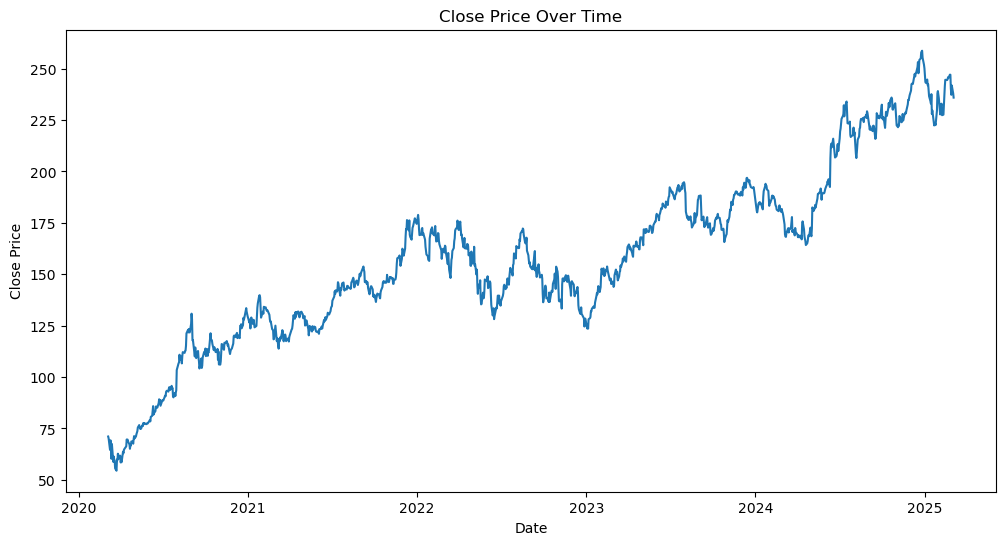

In [5]:
# Plot the Close price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [6]:
# ---------------------------
# Outlier Detection & Handling
# ---------------------------
# Remove outliers from the 'Close' column using a z-score threshold (|z| < 3)
df['Close_z'] = zscore(df['Close'])
df = df[df['Close_z'].abs() < 3]
df.drop(columns=['Close_z'], inplace=True)

In [7]:
# ---------------------------
# Feature Engineering
# ---------------------------
# Create Technical Indicators using ta (instead of pandas_ta)

# 1. Simple Moving Average (SMA) for a 20-day period
df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()

# 2. Exponential Moving Average (EMA) for a 20-day period
df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

# 3. Relative Strength Index (RSI) with a 14-day period
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# 4. Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Hist'] = macd.macd_diff()

# Drop initial rows with NaNs after indicator calculations
df.dropna(inplace=True)

# Generate "Returns" Feature: daily percentage change in 'Close'
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

# Define the binary Target: 1 if next day's Close > today's, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

print(df.head())

                Close       High        Low       Open     Volume      SMA20  \
Date                                                                           
2020-04-23  66.744026  68.374830  66.705197  66.947876  124814400  64.420847   
2020-04-24  68.670891  68.680600  67.222097  67.270635  126161200  64.718493   
2020-04-27  68.719429  69.051898  67.938002  68.386953  117087600  65.148399   
2020-04-28  67.605522  69.364945  67.513310  69.182936  112004800  65.436823   
2020-04-29  69.826042  70.296840  68.894156  69.098005  137280800  65.842583   

                EMA20        RSI      MACD  MACD_Signal  MACD_Hist    Return  \
Date                                                                           
2020-04-23  65.460274  53.385228  0.933222     0.626956   0.306265 -0.003875   
2020-04-24  65.766047  57.200018  1.059673     0.713500   0.346174  0.028869   
2020-04-27  66.047321  57.294826  1.150541     0.800908   0.349633  0.000707   
2020-04-28  66.195722  54.320979  1.119

In [8]:
# ---------------------------
# Data Scaling
# ---------------------------
# Define feature columns; adjust as needed
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA20', 'EMA20', 'RSI', 
            'MACD', 'MACD_Signal', 'MACD_Hist', 'Return']
X = df[features]
y = df['Target']

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [9]:
# ---------------------------
# Train/Test Split: Chronological
# ---------------------------
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled.iloc[:train_size]
X_test  = X_scaled.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("Training set size:", X_train.shape, " Testing set size:", X_test.shape)

Training set size: (977, 12)  Testing set size: (245, 12)


In [26]:
# Cell: Fetch and Process News Sentiment from a News API
import requests
import datetime
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Replace with your NewsAPI key
api_key = "44e0b7ac8f2247c18afa1ffc06168edd"

# Define a date range (for example, one day or a range)
# Use recent dates (e.g., last week) instead of 2022
start_date = datetime.date.today() - datetime.timedelta(days=30)
end_date = datetime.date.today()


daily_sentiments = []
sia = SentimentIntensityAnalyzer()

current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    url = f"https://newsapi.org/v2/everything?q=Apple&from={date_str}&to={date_str}&sortBy=popularity&apiKey={api_key}"
    
    response = requests.get(url)
    if response.status_code == 200:
        news_data = response.json()
        headlines = [article['title'] for article in news_data.get('articles', [])]
        if headlines:
            sentiments = [sia.polarity_scores(headline)['compound'] for headline in headlines]
            avg_sentiment = np.mean(sentiments)
            daily_sentiments.append({'date': date_str, 'num_headlines': len(headlines), 'avg_sentiment': avg_sentiment})
            # print(headlines)
            print(f"Date: {date_str} | Headlines: {len(headlines)} | Avg Sentiment: {avg_sentiment:.4f}")
        else:
            print(f"Date: {date_str} | No headlines found.")
    else:
        print(f"Error fetching news for {date_str}: {response.status_code}")
    current_date += datetime.timedelta(days=1)

# Check if data was collected
if not daily_sentiments:
    print("No sentiment data was collected.")
else:
    df_sentiment = pd.DataFrame(daily_sentiments)
    print("Keys in the sentiment data:", df_sentiment.columns)
    # Convert and set the index if the 'date' key is present
    if 'date' in df_sentiment.columns:
        df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
        df_sentiment.set_index('date', inplace=True)
    print("\nDaily aggregated sentiment:")
    print(df_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Error fetching news for 2025-02-03: 426
Error fetching news for 2025-02-04: 426
Date: 2025-02-05 | Headlines: 99 | Avg Sentiment: 0.0580
Date: 2025-02-06 | Headlines: 99 | Avg Sentiment: 0.0292
Date: 2025-02-07 | Headlines: 100 | Avg Sentiment: 0.0358
Date: 2025-02-08 | Headlines: 99 | Avg Sentiment: 0.1056
Date: 2025-02-09 | Headlines: 99 | Avg Sentiment: 0.1362
Date: 2025-02-10 | Headlines: 98 | Avg Sentiment: 0.0893
Date: 2025-02-11 | Headlines: 100 | Avg Sentiment: 0.0791
Date: 2025-02-12 | Headlines: 97 | Avg Sentiment: 0.0956
Date: 2025-02-13 | Headlines: 99 | Avg Sentiment: 0.0116
Date: 2025-02-14 | Headlines: 96 | Avg Sentiment: 0.1146
Date: 2025-02-15 | Headlines: 100 | Avg Sentiment: 0.0945
Date: 2025-02-16 | Headlines: 99 | Avg Sentiment: 0.0837
Date: 2025-02-17 | Headlines: 99 | Avg Sentiment: -0.0142
Date: 2025-02-18 | Headlines: 99 | Avg Sentiment: 0.0337
Date: 2025-02-19 | Headlines: 100 | Avg Sentiment: -0.0037
Date: 2025-02-20 | Headlines: 97 | Avg Sentiment: 0.0143
Da

In [32]:
# ---------------------------
# Part 3: Merge Sentiment Data into the Technical Data
# ---------------------------
# Merge the sentiment data with the technical data based on the Date index.
enhanced_df = df.join(df_sentiment, how='left')

# For days without sentiment data, fill missing values with neutral sentiment (0) and 0 headlines.
if 'avg_sentiment' in enhanced_df.columns:
    enhanced_df['avg_sentiment'] = enhanced_df['avg_sentiment'].fillna(0)
    
if 'num_headlines' in enhanced_df.columns:
    enhanced_df['num_headlines'] = enhanced_df['num_headlines'].fillna(0)

print("Enhanced DataFrame with Sentiment:")
print(enhanced_df.head())

Enhanced DataFrame with Sentiment:
                Close       High        Low       Open     Volume      SMA20  \
Date                                                                           
2020-04-23  66.744026  68.374830  66.705197  66.947876  124814400  64.420847   
2020-04-24  68.670891  68.680600  67.222097  67.270635  126161200  64.718493   
2020-04-27  68.719429  69.051898  67.938002  68.386953  117087600  65.148399   
2020-04-28  67.605522  69.364945  67.513310  69.182936  112004800  65.436823   
2020-04-29  69.826042  70.296840  68.894156  69.098005  137280800  65.842583   

                EMA20        RSI      MACD  MACD_Signal  MACD_Hist    Return  \
Date                                                                           
2020-04-23  65.460274  53.385228  0.933222     0.626956   0.306265 -0.003875   
2020-04-24  65.766047  57.200018  1.059673     0.713500   0.346174  0.028869   
2020-04-27  66.047321  57.294826  1.150541     0.800908   0.349633  0.000707   
2020

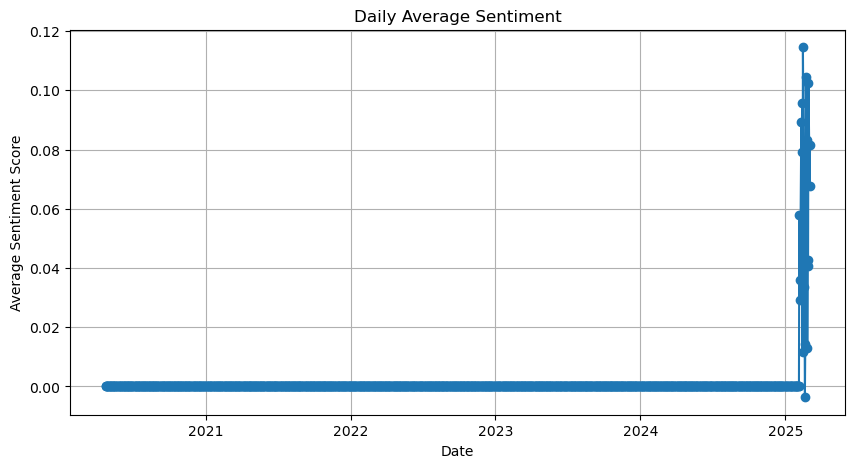

In [28]:
# Optionally, plot the daily average sentiment for visual inspection.
if 'avg_sentiment' in enhanced_df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(enhanced_df.index, enhanced_df['avg_sentiment'], marker='o')
    plt.title("Daily Average Sentiment")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.grid(True)
    plt.show()

# Save the enhanced dataset for future use
enhanced_df.to_csv("data/enhanced_stock_data.csv")

In [4]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def fetch_gdelt_sentiment_apple():
    """
    Queries the GDELT v2 events dataset in BigQuery to retrieve daily average tone
    for rows that mention 'APPLE' in Actor1Name or Actor2Name over the last ~6 months.
    Returns a DataFrame with columns: ['gdelt_sentiment'] indexed by date.
    """
    # Initialize BigQuery client with your project ID (replace with your actual project ID)
    client = bigquery.Client(project="machinelearning111")
    
    # Updated query using SQLDATE instead of EventDate
    query = """
    WITH filtered AS (
      SELECT
        PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) AS event_date,
        AvgTone
      FROM
        `gdelt-bq.gdeltv2.events`
      WHERE
        PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 6 MONTH)
        AND (
          LOWER(Actor1Name) LIKE '%apple%'
          OR LOWER(Actor2Name) LIKE '%apple%'
        )
    )
    SELECT
      event_date AS date,
      AVG(AvgTone) AS daily_tone
    FROM filtered
    GROUP BY date
    ORDER BY date
    """
    
    job = client.query(query)
    results = job.result()
    rows = list(results)
    
    # Convert results to DataFrame
    data = []
    for row in rows:
        data.append({'date': row.date, 'daily_tone': row.daily_tone})
    
    df_gdelt = pd.DataFrame(data)
    if not df_gdelt.empty:
        df_gdelt.set_index('date', inplace=True)
        df_gdelt.rename(columns={'daily_tone': 'gdelt_sentiment'}, inplace=True)
    else:
        df_gdelt = pd.DataFrame(columns=['gdelt_sentiment'])
    
    return df_gdelt

# Fetch GDELT data
df_gdelt = fetch_gdelt_sentiment_apple()
print("\nGDELT DataFrame (Apple mentions) Head:")
print(df_gdelt.head(50))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\johni\anaconda3\envs\stock_env\Lib\site-packages\google\auth\_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)



GDELT DataFrame (Apple mentions) Head:
            gdelt_sentiment
date                       
2024-09-06         0.105530
2024-09-07         1.817757
2024-09-08         1.630386
2024-09-09         0.467267
2024-09-10        -1.905162
2024-09-11        -3.449988
2024-09-12         1.635906
2024-09-13        -0.283459
2024-09-16         2.670940
2024-09-17         1.557093
2024-09-18         5.798077
2024-09-19        -0.736290
2024-09-20         1.916722
2024-09-25        -0.952381
2024-09-26        -1.310861
2024-09-27         0.752028
2024-09-29        -1.658004
2024-09-30         0.971382
2024-10-01        -0.156112
2024-10-02        -1.397950
2024-10-03         1.031810
2024-10-07        -1.928827
2024-10-09        -0.258098
2024-10-10         0.830551
2024-10-16         0.256410
2024-10-21         3.133903
2024-10-23        -0.302133
2024-10-25         2.380145
2024-10-27         4.054054
2024-10-28         0.000000
2024-11-01        -2.059440
2024-11-04        -2.303392
2024-11-

In [2]:
import os
credentials_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
if credentials_path:
    print("Credentials loaded from:", credentials_path)
else:
    print("No GOOGLE_APPLICATION_CREDENTIALS variable set; Application Default Credentials will be used.")


Credentials loaded from: C:\Users\johni\AppData\Roaming\gcloud\application_default_credentials.json


In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\johni\AppData\Roaming\gcloud\application_default_credentials.json"


In [5]:
from google.cloud import bigquery

# Replace 'YOUR_PROJECT_ID' with the project ID you created.
client = bigquery.Client(project="machinelearning111")

# Your query code follows...
query = """
WITH filtered AS (
  SELECT
    PARSE_DATE('%Y%m%d', CAST(EventDate AS STRING)) AS event_date,
    AvgTone
  FROM
    `gdelt-bq.gdeltv2.events`
  WHERE
    PARSE_DATE('%Y%m%d', CAST(EventDate AS STRING)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 6 MONTH)
    AND (
      LOWER(Actor1Name) LIKE '%apple%'
      OR LOWER(Actor2Name) LIKE '%apple%'
    )
)
SELECT
  event_date AS date,
  AVG(AvgTone) AS daily_tone
FROM filtered
GROUP BY date
ORDER BY date
"""
job = client.query(query)
results = job.result()
rows = list(results)

data = []
for row in rows:
    data.append({'date': row.date, 'daily_tone': row.daily_tone})
    
df_gdelt = pd.DataFrame(data)
if not df_gdelt.empty:
    df_gdelt.set_index('date', inplace=True)
    df_gdelt.rename(columns={'daily_tone': 'gdelt_sentiment'}, inplace=True)
else:
    df_gdelt = pd.DataFrame(columns=['gdelt_sentiment'])

print("GDELT DataFrame Head:")
print(df_gdelt.head())


BadRequest: 400 Unrecognized name: EventDate; Did you mean EventCode? at [9:31]